In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans 
from scipy.interpolate import make_interp_spline
from matplotlib.colors import ListedColormap, BoundaryNorm



def extend_X(Xh):
    """
    Extend all vectors in Xh by 1 in the first component.
    """
    X = np.ones((Xh.size//Xh.shape[-1], Xh.shape[-1]+1))
    X[:, 1:] = Xh
    return X

def softmax(W):
    """
    Compute the softmax function for each row of the input matrix W.
    """
    return np.exp(W) / np.sum(np.exp(W), axis=1, keepdims=True)


def h(Xh, Theta):
    """
    Prediction rule for input data Xh and parameters Theta.
    """
    return softmax(extend_X(Xh) @ Theta)

def loss(Xh, Theta, Y):
    """
    Cross-entropy loss for input data Xh, parameters Theta, and one-hot encoded labels Y.
    """
    return -np.sum(Y * np.log(h(Xh, Theta))) / Xh.shape[0]

def shuffle_split_data(X,Y,Ntest=50):
    """
    Shuffle and split data into training and test sets, with Ntest samples in the test set.
    """
    m = X.shape[0]
    all_range = np.arange(m)  # index array of all data points
    np.random.shuffle(all_range)
    test_range = all_range[:Ntest]  # index array of the test range
    train_range = all_range[Ntest:]  # complement array of the training range
    return X[train_range], Y[train_range], X[test_range], Y[test_range]

def UndersamplingFeatures(Xh):
    """
    Simple undersampling of features by selecting every 100th measurement
    """
    return Xh[:, 700:1700:100]


def OrderClusterLabels(labels, X):
    """
    Order cluster labels by increasing smallest 0th coordinate of x in each cluster.
    labels should contain values between 0 and K-1, where K is the number of clusters.
    """
    K = np.max(labels)+1
    cluster_x0 = [X[(labels==i).nonzero(), 0].min() for i in range(K)]
    reorder = np.arange(K)
    reorder[np.argsort(cluster_x0)] = np.arange(K)
    return reorder[labels]


def test_grad1():
    """ 
    Unit test for grad_loss in Q1
    """
    Xh = np.array([[1]])
    Theta = np.array([[0.5], [1]])
    Y = np.array([[1]])
    assert np.linalg.norm(grad_loss(Xh, Theta, Y))<1e-7, "test_grad1 detected a wrong gradient value"

def test_grad2():
    """ 
    Unit test for grad_loss in Q1
    """
    Xh = np.array([[-1]])
    Theta = np.array([[1,0,0], [1,0,0]])
    Y = np.array([[0.5,0,0.5]])
    G_exact = np.array([[-1/6,1/3,-1/6], [1/6,-1/3,1/6]])
    assert np.linalg.norm(grad_loss(Xh, Theta, Y) - G_exact)<1e-7, "test_grad2 detected a wrong gradient value"


def test_grad3():
    """ 
    Unit test for grad_loss in Q1
    """
    Xh = np.array([[1,0], [0,1]])
    Theta = np.array([[1,0], [0,1], [0,1]])
    Y = np.array([[0,1], [0.25,0.75]])
    G_exact = np.array([[3/8,-3/8], [1/4,-1/4], [1/8,-1/8]])
    assert np.linalg.norm(grad_loss(Xh, Theta, Y) - G_exact)<1e-7, "test_grad3 detected a wrong gradient value"

In [2]:

def grad_loss(Xh, Theta, Y):
    N = Xh.shape[0]
    predictions = h(Xh, Theta)
    X = extend_X(Xh)
    return (1/N) * (X.T @ (predictions - Y))


In [3]:

def agd(Xtrain, Ytrain, Xtest, Ytest, Theta0, t=1, p=100, q=0.999, S=1000, eps=1e-8):
    Thetas = [Theta0]
    losses = [loss(Xtest,Theta0,Ytest)]
    for s in range(S):
        if s >= p and losses[s]> q * losses[s-p]:
            break
        G = grad_loss(Xtrain, Thetas[s],Ytrain)
        N = G.shape[0]
        M = G.shape[1]
        v = np.sum(G**2) / (N * M)
        Thetanew = (Thetas[s])-(t*G/(np.sqrt(v)+eps))
        Thetas.append(Thetanew)
        losses.append(float(loss(Xtest,Thetanew,Ytest)))

    argmin = min(losses)
    S_star = np.where(np.array(losses) == argmin)
    K_star = S_star[0][0]
    Theta_s = Thetas[K_star]
    return(Theta_s, K_star,losses)
    

In [4]:
np.random.seed(1)

data = np.load("CWData.npz")
Xh = data['Xh']
Y = data['Y']
Xhnew = data['Xhnew']
Energies = data['Energies']

Zh = UndersamplingFeatures(Xh)
Zhnew = UndersamplingFeatures(Xhnew)

Zhtrain,Ytrain,Zhtest, Ytest = shuffle_split_data(Zh,Y, Ntest = 50)

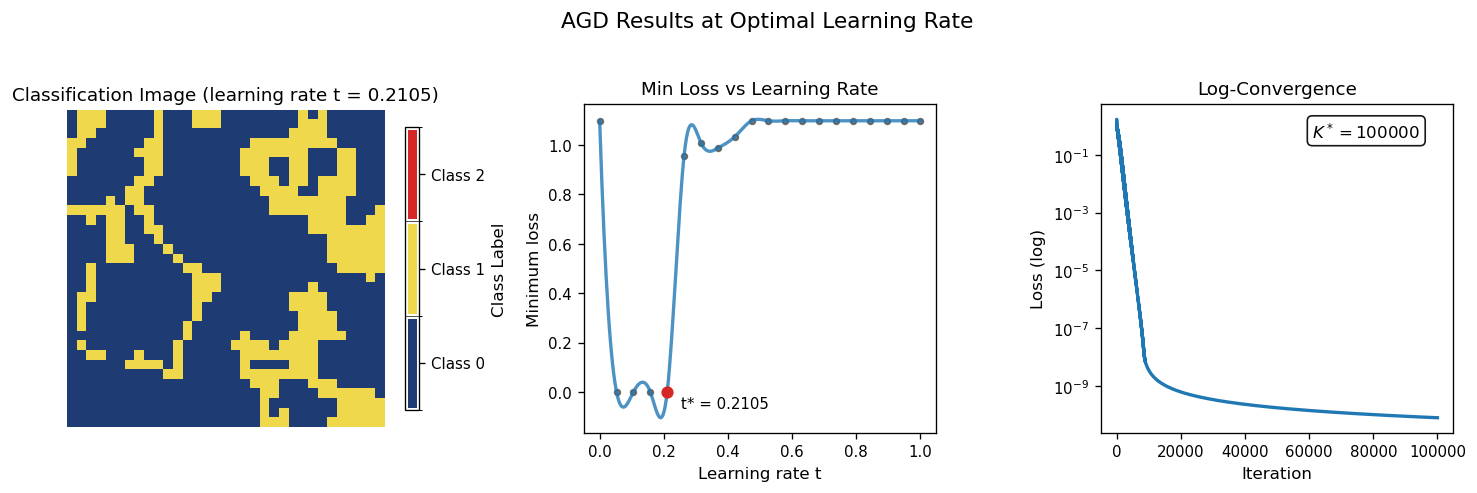

In [5]:

features = Zhtrain.shape[1]
Theta0 =  np.zeros((features + 1,3))

trange = np.linspace(0,1,20)
minlosses = []
iters = []
for k in trange:
    a = agd(Zhtrain,Ytrain,Zhtest,Ytest,Theta0,S = 100000 ,t = k)
    b = a[2]
    c = a[1]
    minlosses.append(min(b))
    iters.append(c)   

min_losses = np.array(minlosses)
t_range = np.array(trange)
toptimal = t_range[np.argmin(min_losses)]
best_loss = min_losses[np.argmin(min_losses)]
optimal_iters = iters[np.argmin(min_losses)]

grad_optimal = agd(Zhtrain,Ytrain,Zhtest,Ytest,Theta0,S= 100000, t = toptimal)

Ynew = h(Zhnew, grad_optimal[0])
Pred_labels = np.argmax(Ynew, axis = 1)
c = Pred_labels.reshape(33,33)

plt.rcParams.update({
    "figure.dpi": 120,
    "font.size": 11,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "lines.linewidth": 2
})

t_smooth = np.linspace(t_range.min(), t_range.max(), 300)
spline = make_interp_spline(t_range, minlosses, k=3)
minlosses_smooth = spline(t_smooth)


fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("AGD Results at Optimal Learning Rate", fontsize=13, y=1.02)

cmap = ListedColormap(["#1f3b73", "#f0d84c", "#d62728"])
bounds = [-0.5, 0.5, 1.5, 2.5]
norm = BoundaryNorm(bounds, cmap.N)

im = axes[0].imshow(c, cmap=cmap, norm=norm)
axes[0].set_title(f"Classification Image (learning rate t = {toptimal:.4f})", fontsize=11)
axes[0].axis("off")

cbar = fig.colorbar(
    im,
    ax=axes[0],
    ticks=[0, 1, 2],
    boundaries=bounds,
    spacing="proportional",   
    fraction=0.040,           
    pad=0.06,                 
    drawedges=True
)

cbar.set_label("Class Label", fontsize=10)
cbar.set_ticklabels(["Class 0", "Class 1", "Class 2"])
cbar.ax.tick_params(labelsize=9)

cbar.solids.set_edgecolor("white")
cbar.solids.set_linewidth(2.0)

cbar.outline.set_linewidth(0.8)

axes[1].plot(t_smooth, minlosses_smooth, alpha=0.8)
axes[1].scatter(trange, minlosses, s=12, color="#444444", alpha=0.7)
axes[1].scatter(toptimal, best_loss, s=40, color="#d62728", zorder=3)


axes[1].set_title("Min Loss vs Learning Rate", fontsize=11)
axes[1].set_xlabel("Learning rate t", fontsize=10)
axes[1].set_ylabel("Minimum loss", fontsize=10)
axes[1].grid(False)
axes[1].tick_params(labelsize=9)

axes[1].annotate(
    f"t* = {toptimal:.4f}",
    (toptimal, best_loss),
    textcoords="offset points",
    xytext=(8, -10),
    fontsize=9
)

losses_opt = np.array(grad_optimal[2])
iters = np.arange(len(losses_opt))

axes[2].semilogy(iters, losses_opt)
axes[2].text(
    0.60, 0.95,
    f"$K^* = {optimal_iters}$",
    transform=axes[2].transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=dict(
        boxstyle="round",
        facecolor="white",
        edgecolor="black",
        alpha=0.9
    )
)
axes[2].set_title("Log-Convergence", fontsize=11)
axes[2].set_xlabel("Iteration", fontsize=10)
axes[2].set_ylabel("Loss (log)", fontsize=10)
axes[2].grid(False)
axes[2].tick_params(labelsize=9)

for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.8)

plt.tight_layout()
plt.show()

In [6]:

def ClusterFeaturesFit(K, Xh, Energies):
    X_clustering = np.concatenate((Energies.reshape(3959,1),Xh.T), axis = 1)
    kmeans = KMeans(n_clusters = K, random_state = 0, n_init= 20).fit(X_clustering)
    labels = OrderClusterLabels(kmeans.labels_, X_clustering)
    return labels

def ClusterFeaturesPredict(labels, Xh):
    K = np.max(labels) + 1
    N = Xh.shape[0]
    Zh = np.zeros((N, K))
    
    for k in range(K):
        Zh[:, k] = Xh[:, labels ==k].mean(axis = 1)
            
    return Zh

In [7]:
labels = ClusterFeaturesFit(10, Xh, Energies)
Zh =  ClusterFeaturesPredict(labels, Xh)
Zhnew = ClusterFeaturesPredict(labels, Xhnew)
Zhtrain,Ytrain,Zhtest, Ytest = shuffle_split_data(Zh,Y,Ntest = 50)
ext = extend_X(Zhtrain)
a = ext.shape[1]
Theta0 = np.zeros((a, 3))

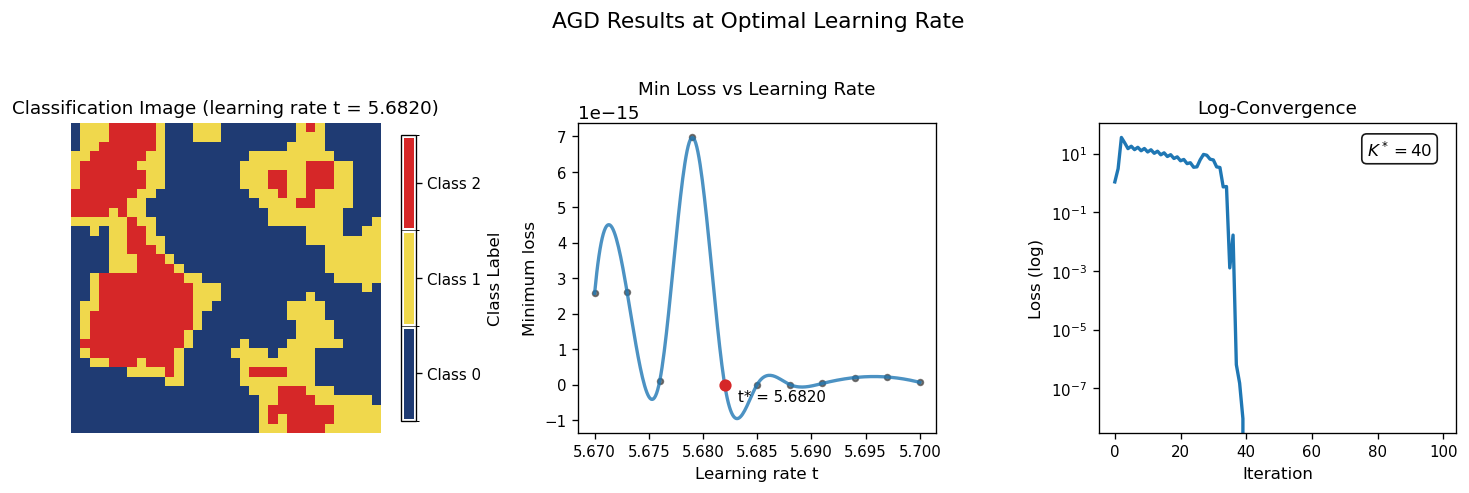

In [8]:

trange = np.linspace(5.67,5.7,11)
minlosses = []
iters = []
for k in trange:
    a = agd(Zhtrain,Ytrain,Zhtest,Ytest,Theta0,S = 100000 ,t = k)
    b = a[2]
    c = a[1]
    minlosses.append(min(b))
    iters.append(c)   

min_losses = np.array(minlosses)
t_range = np.array(trange)
toptimal = t_range[np.argmin(min_losses)]
best_loss = min_losses[np.argmin(min_losses)]
optimal_iters = iters[np.argmin(min_losses)]

grad_optimal = agd(Zhtrain,Ytrain,Zhtest,Ytest,Theta0,S= 100000, t = toptimal)

Ynew = h(Zhnew, grad_optimal[0])
Pred_labels = np.argmax(Ynew, axis = 1)
c = Pred_labels.reshape(33,33)

t_smooth = np.linspace(t_range.min(), t_range.max(), 300)
spline = make_interp_spline(t_range, minlosses, k=3)
minlosses_smooth = spline(t_smooth)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("AGD Results at Optimal Learning Rate", fontsize=13, y=1.02)

cmap = ListedColormap(["#1f3b73", "#f0d84c", "#d62728"])
bounds = [-0.5, 0.5, 1.5, 2.5]
norm = BoundaryNorm(bounds, cmap.N)

im = axes[0].imshow(c, cmap=cmap, norm=norm)
axes[0].set_title(f"Classification Image (learning rate t = {toptimal:.4f})", fontsize=11)
axes[0].axis("off")

cbar = fig.colorbar(
    im,
    ax=axes[0],
    ticks=[0, 1, 2],
    boundaries=bounds,
    spacing="proportional",   
    fraction=0.040,           
    pad=0.06,                 
    drawedges=True
)

cbar.set_label("Class Label", fontsize=10)
cbar.set_ticklabels(["Class 0", "Class 1", "Class 2"])
cbar.ax.tick_params(labelsize=9)

cbar.solids.set_edgecolor("white")
cbar.solids.set_linewidth(2.0)

cbar.outline.set_linewidth(0.8)

axes[1].plot(t_smooth, minlosses_smooth, alpha=0.8)
axes[1].scatter(trange, minlosses, s=12, color="#444444", alpha=0.7)
axes[1].scatter(toptimal, best_loss, s=40, color="#d62728", zorder=3)

axes[1].set_title("Min Loss vs Learning Rate", fontsize=11)
axes[1].set_xlabel("Learning rate t", fontsize=10)
axes[1].set_ylabel("Minimum loss", fontsize=10)
axes[1].grid(False)
axes[1].tick_params(labelsize=9)

axes[1].annotate(
    f"t* = {toptimal:.4f}",
    (toptimal, best_loss),
    textcoords="offset points",
    xytext=(8, -10),
    fontsize=9
)

losses_opt = np.array(grad_optimal[2])
iters = np.arange(len(losses_opt))

axes[2].semilogy(iters[:100], losses_opt[:100])
axes[2].text(
    0.75, 0.95,
    f"$K^* = {optimal_iters}$",
    transform=axes[2].transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=dict(
        boxstyle="round",
        facecolor="white",
        edgecolor="black",
        alpha=0.9
    )
)
axes[2].set_title("Log-Convergence", fontsize=11)
axes[2].set_xlabel("Iteration", fontsize=10)
axes[2].set_ylabel("Loss (log)", fontsize=10)
axes[2].grid(False)
axes[2].tick_params(labelsize=9)

for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.8)

plt.tight_layout()
plt.show()